In [22]:
import io
import time
from datetime import datetime
%load_ext autoreload
%autoreload 2

import os
import random

import mlflow
import numpy as np
import pandas as pd
from dotenv import load_dotenv

from src.functions import create_model, plot_data, predict_with_uncertainty, create_train_val_datasets, \
    load_stations_from_path, create_test_datasets, create_test_dataset, check_gpus
from src.utils import setup_logger, format_with_border, measure_execution_time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
check_gpus()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [24]:
load_dotenv()
mlflow_port = os.getenv('MLFLOW_PORT')
mlflow_uri = f'http://localhost:{mlflow_port}'
mlflow_experiment_name = f'Active Learning Simulation'
train_path = os.getenv('LS_LABELED_TRAIN_DATA_PATH')
test_path = os.getenv('LS_LABELED_TEST_DATA_PATH')

mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment(mlflow_experiment_name)
mlflow.tensorflow.autolog()

def log_parameters(iteration):
    global_vars = globals()
    for var_name, value in global_vars.items():
        if var_name.isupper():
            logging.info(f'{var_name}: {value}')
            mlflow.log_param(f'al_{var_name.lower()}', value)
    mlflow.log_param('al_iteration', iteration)

2023/11/11 08:55:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [30]:
SEQUENCE_LENGTH = 20
TARGET_START_INDEX = SEQUENCE_LENGTH - 1
FEATURE_COLUMNS = ['HS', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
TARGET_COLUMN = 'no_snow'
DATE_COLUMN = 'measure_date'
SPLIT_PERCENTAGE = 0.8
DATASET_BATCH_SIZE = 64

# Active learning
UNCERTAINTY_ITERATIONS = 5

# Model configuration
# MODEL_ARCHITECTURE = "128(l)-64-8(d)-1"
MODEL_ARCHITECTURE = "64(l)-8(d)-1"
MODEL_INPUT_SHAPE = (SEQUENCE_LENGTH, len(FEATURE_COLUMNS))
MODEL_DROPOUT_RATE = 0.5
MODEL_OPTIMIZER = 'adam'
MODEL_METRICS = ['accuracy']
MODEL_LOSS = 'binary_crossentropy'
MODEL_BATCH_SIZE = 64
MODEL_EPOCHS = 5

In [31]:
model = create_model(MODEL_ARCHITECTURE, MODEL_INPUT_SHAPE, logging=None, dropout_rate=0.5, summary=False)
model.compile(
    optimizer=MODEL_OPTIMIZER,
    metrics=MODEL_METRICS,
    loss=MODEL_LOSS
)

training_stations = {station.iloc[0]['station_code']: station for station in load_stations_from_path(train_path)}
testing_stations = {station.iloc[0]['station_code']: station for station in load_stations_from_path(test_path)}

In [32]:
active_stations = [random.choice(list(training_stations.keys()))]
summary = []
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
run_name = f"Run_{current_time}"

with mlflow.start_run(run_name=run_name):
    for i, _ in enumerate(training_stations.items()):
        iteration_start_time = time.time()
        with mlflow.start_run(run_name=f'Iteration {i}', nested=True):
            logging, tmp_log_file = setup_logger(log_file='active_learning_simulation.log')
            logging.info(format_with_border(f'Iteration {i}'))
            log_parameters(i)
            logging.info(f"Active Station: {active_stations[-1]}")
            mlflow.log_param('al_active_station', active_stations[-1])

            # 1. Parse and split labeled data
            logging.info(format_with_border('Preparing Training Data'))
            logging.info(f"Stations: {', '.join(active_stations)}")
            mlflow.log_param('al_training_station_names', active_stations)
            train_dataset, val_dataset, mean, std, num_train_samples, num_val_samples, _ = create_train_val_datasets(
                [training_stations[name] for name in active_stations],
                SPLIT_PERCENTAGE,
                FEATURE_COLUMNS,
                TARGET_COLUMN,
                SEQUENCE_LENGTH,
                TARGET_START_INDEX,
                DATASET_BATCH_SIZE
            )
            logging.info(f"Training samples: {num_train_samples}")
            logging.info(f"Validation samples: {num_val_samples}")
            mlflow.log_param('al_training_samples', num_train_samples)
            mlflow.log_param('al_validation_samples', num_val_samples)

            # 2. Fit model
            logging.info(format_with_border('Fitting Model'))
            @measure_execution_time
            def fit_model():
                model.fit(
                    train_dataset,
                    epochs=MODEL_EPOCHS,
                    batch_size=MODEL_BATCH_SIZE,
                    validation_data=val_dataset
                )
            history, elapsed_fitting_time = fit_model()
            logging.info(f'Model fitting completed in {elapsed_fitting_time}')
            mlflow.log_param('al_model_fitting_time', elapsed_fitting_time)

            # 3. Evaluate model on test data
            logging.info(format_with_border('Evaluating Model on Test Data'))
            test_datasets = create_test_datasets(
                testing_stations.values(), FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE, mean, std
            )
            all_evaluation_results = np.empty((0, 2), float)
            for j, dataset in enumerate(test_datasets):
                evaluation_results = model.evaluate(dataset, verbose=0)
                station_name = list(testing_stations.keys())[j]
                test_df = list(testing_stations.values())[j]
                logging.info(
                    f'Station: {station_name}, Samples: {len(test_df)}, Loss: {evaluation_results[0]:.2f}, Accuracy: {evaluation_results[1]:.2f}'
                )
                all_evaluation_results = np.append(all_evaluation_results, [evaluation_results], axis=0)

            mlflow.log_metric('test_avg_loss', np.mean(all_evaluation_results[:, 0]))
            mlflow.log_metric('test_avg_accuracy', np.mean(all_evaluation_results[:, 1]))

            # 4. Predict and assign uncertainty scores for unlabeled tasks
            logging.info(format_with_border('Assigning Uncertainty Scores'))
            uncertainties = {}
            for station_name, station_df in training_stations.items():
                if station_name in active_stations:
                    continue
                test_dataset = create_test_dataset(
                    station_df, FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE, mean, std
                )
                _, uncertainty_score = predict_with_uncertainty(model, test_dataset, n_iter=UNCERTAINTY_ITERATIONS)
                uncertainties[station_name] = uncertainty_score
                logging.info(f'Station: {station_name}, Uncertainty Score: {uncertainty_score:.4f}')
                
            most_uncertain_station_name = max(uncertainties, key=uncertainties.get) if uncertainties else ''
            logging.info(f'Most uncertain station: {most_uncertain_station_name}')

            # 5. Done
            summary.append({
                'iteration': i,
                'active_learning_train': active_stations,
                'active_learning_predict': list(uncertainties.keys()),
                'evaluation_results': evaluation_results,
                'uncertainty_scores': uncertainties,
                'most_uncertain': most_uncertain_station_name
            })

            active_stations.append(most_uncertain_station_name)
            logging.info(format_with_border('Done'))
            iteration_duration = time.time() - iteration_start_time
            minutes, seconds = divmod(iteration_duration, 60)
            formatted_time = f"{int(minutes)}m{int(seconds)}s"
            logging.info(f'Iteration completed in {formatted_time}')
            mlflow.log_param('al_iteration_completion_time', formatted_time)

            mlflow.log_artifact(tmp_log_file)

    markdown = pd.DataFrame(summary).to_markdown(index=False)
    mlflow.log_text(markdown, 'summary.md')
    mlflow.log_artifact(tmp_log_file)

2023-11-11 09:17:53 INFO 2749851394 - <module>: =========================================== Iteration 0 ===========================================
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: SEQUENCE_LENGTH: 20
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: TARGET_START_INDEX: 19
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: FEATURE_COLUMNS: ['HS', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: TARGET_COLUMN: no_snow
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: DATE_COLUMN: measure_date
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: SPLIT_PERCENTAGE: 0.8
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: DATASET_BATCH_SIZE: 64
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: UNCERTAINTY_ITERATIONS: 5
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: MODEL_ARCHITECTURE: 64(l)-8(d)-1
2023-11-11 09:17:53 INFO 1453909833 - log_parameters: MODEL_INPUT_SHAPE: (20, 5)
2023-11-11 09:17:

174/174 [==============================] - 1s 3ms/step


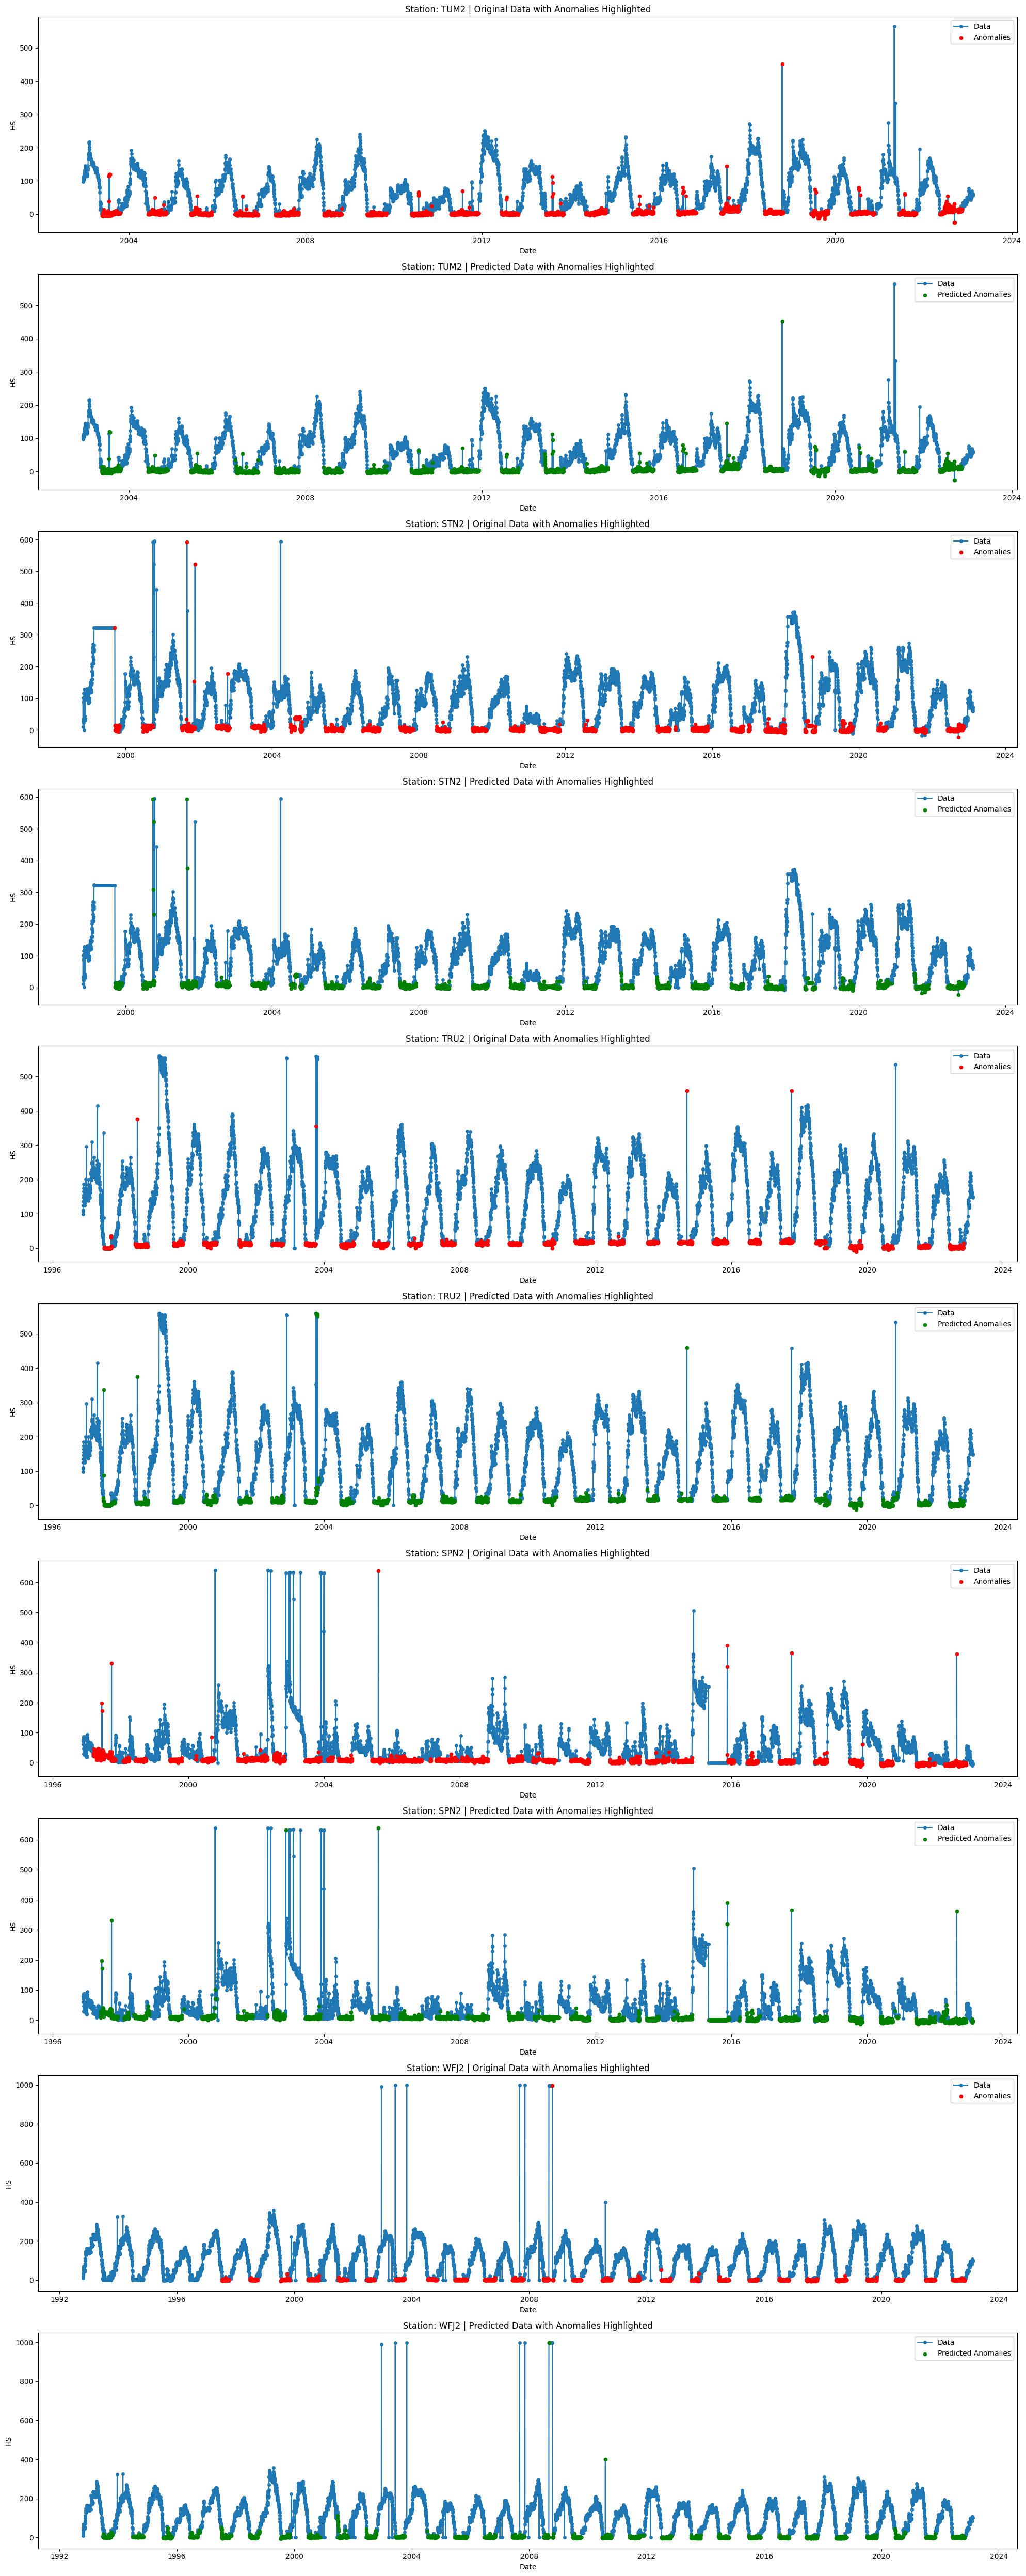

In [33]:
predictions = [model.predict(td).reshape((-1,)) > 0.5 for td in test_datasets]

plot_data(
    [test_station[TARGET_START_INDEX:] for test_station in testing_stations.values()],
    predictions=predictions
)